<a href="https://colab.research.google.com/github/Kalgrand/SPAM/blob/main/spam_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ilość początkowa:
class 0: (4825, 2)
class 1: (747, 2) 



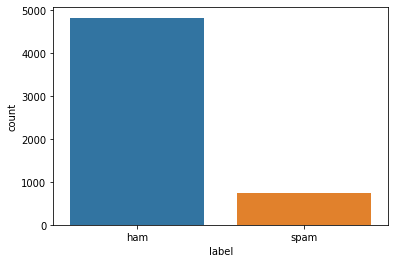

Random undersampling:
spam    747
ham     747
Name: label, dtype: int64 



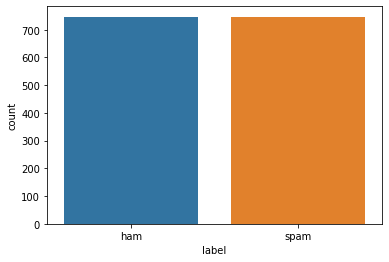

Random oversampling:
spam    4825
ham     4825
Name: label, dtype: int64 



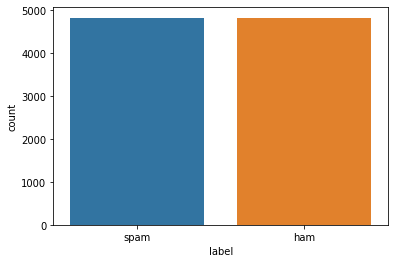

In [163]:
#klasyfikator spamu - nauka

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import pickle
import tensorflow as tf
import wordcloud

plik = pd.read_csv("spam.csv",encoding='latin-1')
plik.head()

data = plik.copy()
data.drop(columns=["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], inplace=True)

# zmiana nazwy kolumn
data = data.rename(columns={"v1":"label", "v2":"text"})
data.head()

# zliczanie klasy
class_count_0, class_count_1 = data.label.value_counts()

# podzielenie na spam i ham
class_0 = data[data['label'] == 'ham']
class_1 = data[data['label'] == 'spam']

print('Ilość początkowa:')
print('class 0:', class_0.shape)
print('class 1:', class_1.shape, "\n")
sns.countplot(data['label'])
plt.show()
#/////////////////////////

# random undersampling
class_0_under = class_0.sample(class_count_1)
test_under = pd.concat([class_0_under, class_1], axis=0)
print('Random undersampling:')
print(test_under['label'].value_counts(), "\n")

# wykres
sns.countplot(test_under['label'])
plt.show()

#/////////////////////////

# random oversampling
class_1_over = class_1.sample(class_count_0, replace=True)
test_over = pd.concat([class_1_over, class_0], axis=0)
print('Random oversampling:')
print(test_over['label'].value_counts(), "\n")

# wykres
sns.countplot(test_over['label'])
plt.show()

data['label'] = data['label'].map({'spam':1, 'ham':0})

In [165]:
# wstępne przetwarzanie tekstu
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# budowanie modelu
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.callbacks import EarlyStopping

# dzielenie danych na train and test set
from sklearn.model_selection import train_test_split

x = data['text'].values
y = data['label'].values
x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                        test_size=0.30,
                                                    random_state=42)

# zdefiniowanie modelu
model = Sequential()
model.add(Embedding(vocab_size, 24, input_length=max_length))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# kompilacja modelu
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

# podsumowanie modelu
print(model.summary())

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# dopasowanie modelu
model.fit(x=padded_train,
         y=y_train,
         epochs=10,
         validation_data=(padded_test, y_test), verbose=1,
         callbacks=[early_stop]
         )

# ocena modelu
loss, accuracy = model.evaluate(padded_test, y_test, verbose=0)
print('Accuracy: %f' % (accuracy*100))

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, 8, 24)             177936    
_________________________________________________________________
flatten_24 (Flatten)         (None, 192)               0         
_________________________________________________________________
dense_96 (Dense)             (None, 500)               96500     
_________________________________________________________________
dense_97 (Dense)             (None, 200)               100200    
_________________________________________________________________
dropout_24 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_98 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_99 (Dense)             (None, 1)               

INFO:tensorflow:Assets written to: spam_model/assets
1 = SPAM , 0 = HAM 

Wynik : 1 



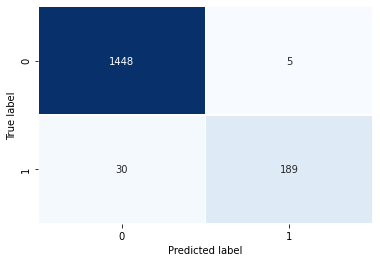

In [166]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer

# tablica pomyłek
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.5,  
                cmap="Blues", cbar=False)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(y_test, preds)

# zapisanie modelu i tokenizera
model.save("spam_model")
with open('spam_model/tokenizer.pkl', 'wb') as output:
    pickle.dump(t, output, pickle.HIGHEST_PROTOCOL)

# załadowanie modelu
s_model = tf.keras.models.load_model("spam_model")
with open('spam_model/tokenizer.pkl', 'rb') as input:
    tokener = pickle.load(input)

# ocena modelu
sms = ["We know someone who you know that fancies you. Call 09058097218 to find out who. POBox 6, LS15HB "]
sms1 = ["Even my brother is not like to speak with me. They treat me like aids patent."]
sms_proc = tokener.texts_to_sequences(sms)
sms_proc = pad_sequences(sms_proc, maxlen=max_length, padding='post')
pred = (model.predict(sms_proc) > 0.5).astype("int32").item()
print("1 = SPAM , 0 = HAM \n")
print("Wynik :", pred, "\n")